In [1]:
import qubic.toolchain as _tc
import qubic.rpc_client as _rc
import qubitconfig.qchip as _qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import numpy as np
import matplotlib.pyplot as plt
import chipcalibration.cross_resonance_cal as _cr
import chipcalibration.cr_rpe as _cr_rpe
from importlib import reload
import qubic.state_disc as _sd
import chipcalibration.config as _cfg
import qubic.job_manager as _jm
import chipcalibration.rabi_experiments as _rabi
from tqdm import tqdm
from scipy.optimize import curve_fit


In [2]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 'jump_cond_clks': 5, 'jump_fproc_clks': 5, 'pulse_regwrite_clks': 3})

qchipname = 'X4Y2'
fpga_config, qchip, channel_config = _cfg.load_configs(qchipname, qchip_file='qubitcfg.json')

runner = _rc.CircuitRunnerClient(ip='192.168.1.247')
jm = _jm.JobManager(fpga_config, channel_config, runner, qchip)

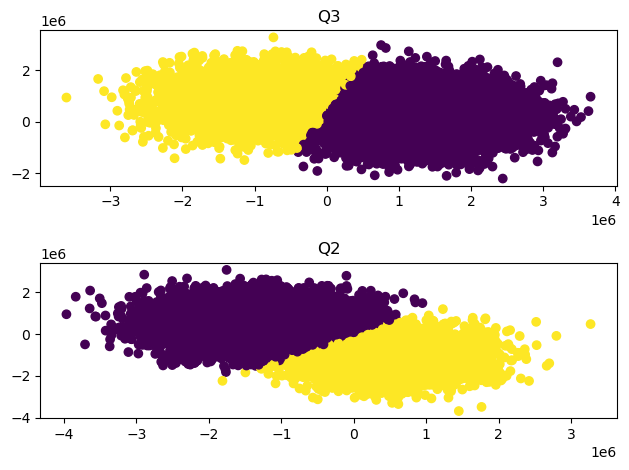

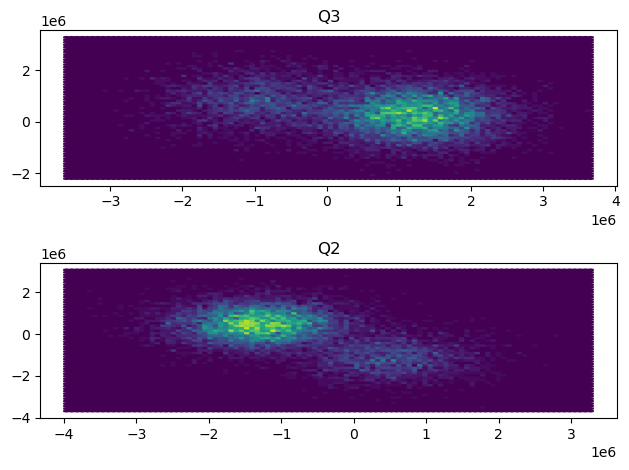

In [3]:
register = ['Q3', 'Q2']
pulse_width_interval = np.linspace(1e-9, 100e-9, 10)

gmm_rabi = _rabi.GMMRabi(register, pulse_width_interval=pulse_width_interval, 
                       channel_configs=channel_config)

gmm_rabi.run_and_report(jm, 1000, qchip)

In [70]:
jm = _jm.PyGSTiJobManager(fpga_config, channel_config, runner, qchip, gmm_rabi.gmm_manager)

In [98]:
reload(_cr_rpe)

<module 'chipcalibration.cr_rpe' from '/home/jpmarceaux/chipcalibration/chipcalibration/cr_rpe.py'>

In [99]:
calibration = {
    'twidth' : 247.e-9, 
    'c_amp' : 0.4, 
    'c_phase' : -0.622,
    't_amp' : 0, 
    't_phase' : 0
}

In [100]:
rpe_exp = _cr_rpe.CR_RPE_Experiment('Q3', 'Q2', calibration, 9)

In [101]:
rpe_exp.qubic_instructions

{Circuit(Gxpi2:Q2Gxpi2:Q2Gcr:Q3:Q2Gxpi2:Q2@(Q3,Q2)): [{'name': 'delay',
   't': 0.0004},
  {'name': 'X90', 'qubit': ['Q2']},
  {'name': 'barrier', 'qubit': ['Q3', 'Q2']},
  {'name': 'X90', 'qubit': ['Q2']},
  {'name': 'barrier', 'qubit': ['Q3', 'Q2']},
  {'name': 'pulse',
   'freq': 'Q2.freq',
   'dest': 'Q3.qdrv',
   'twidth': 1.235e-07,
   'amp': 0.4,
   'phase': -0.622,
   'env': [{'env_func': 'cos_edge_square',
     'paradict': {'ramp_fraction': 0.25}}]},
  {'name': 'pulse',
   'freq': 'Q2.freq',
   'dest': 'Q2.qdrv',
   'twidth': 1.235e-07,
   'amp': 0,
   'phase': 0,
   'env': [{'env_func': 'cos_edge_square',
     'paradict': {'ramp_fraction': 0.25}}]},
  {'name': 'barrier'},
  {'name': 'delay', 't': 1e-08},
  {'name': 'X90', 'qubit': ['Q3']},
  {'name': 'X90', 'qubit': ['Q3']},
  {'name': 'barrier'},
  {'name': 'delay', 't': 1e-08},
  {'name': 'pulse',
   'freq': 'Q2.freq',
   'dest': 'Q3.qdrv',
   'twidth': 1.235e-07,
   'amp': 0.4,
   'phase': 2.5195926535897932,
   'env': [{'

In [102]:
rpe_exp.run(jm, 1000, qchip)

In [105]:
reload(_cr_rpe)

<module 'chipcalibration.cr_rpe' from '/home/jpmarceaux/chipcalibration/chipcalibration/cr_rpe.py'>

In [106]:
anz = _cr_rpe.CR_RPE_Analyzer(rpe_exp)

In [107]:
anz.process_rpe(rpe_exp.ds)

Generation of last good estimate:  7
Trusted theta_ix : 0.002701759724198838
Trusted theta_zx : 1.6858206025438665
Trusted theta_zi : -0.01790338452804674
